In [1]:
import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics

#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import scikitplot as skplt
import sklearn as sk
from sklearn import linear_model

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [3]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [4]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_taylor2, load_taylor1a,load_misery, time_split
from common.calc_metrics import model_results

# Setup

## variables

In [5]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [6]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_test', train0_df['FEDFUNDS'], train0_df['ffef_tr'], train0_df.shape[0], 2  , None )
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('ffef_tr2_test', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], train0_df.shape[0], 2  , model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('Naive_test', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , model_stats_df )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

model_stats_df

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
holston_df: (250, 4)
train_df:  (200, 18)
test_df:  (50, 18)


,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_test,-0.9567,-0.9666,22.8365,4.7788
1,ffef_tr_test,-39.0258,-39.8596,54.7667,7.4005
2,ffef_tr2_test,0.4458,0.4430,6.4680,2.5432
3,ffef_tr2_test,-13.4214,-13.7219,19.7326,4.4421
4,Naive_test,0.9206,0.9206,0.9263,0.9624
5,Naive_test,0.8830,0.8830,0.1601,0.4002


# Load Data

In [7]:
taylor_df = load_taylor()
train_df, test_df = time_split(taylor_df)

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
holston_df: (250, 4)
train_df:  (200, 18)
test_df:  (50, 18)


In [60]:
taylor_df['chair_name'].unique()

array(['Martin', 'Burns', 'Miller', 'Volcker', 'Greenspan', 'Bernanke',
       'Yellen', 'Powell'], dtype=object)

In [9]:
X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_gdp','recession_flag','Real_Interest_Rate','gap_ue','chair_name']]
y_train = train_df['FEDFUNDS']


X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_gdp','recession_flag','Real_Interest_Rate','gap_ue','chair_name']]
y_test = test_df['FEDFUNDS']

In [10]:
# Initialize Imputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

# Initialize Transformer / OneHotEncoder
cat_columns_lst = ['recession_flag','chair_name']
num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_gdp','Real_Interest_Rate','gap_ue']


ohe_categories = list()
for c in cat_columns_lst:
    ohe_categories.append(list(X_train[c].unique()))
    
ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                   sparse_output=False, handle_unknown='ignore')

transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
categorical_transformer = Pipeline( steps=[('transformer',transformer)])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns_lst),
        ("cat", categorical_transformer, cat_columns_lst),
    ]
)

In [11]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
X_train_trf.columns = t_fit.get_feature_names_out()
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)

print('X_train_trf: ', X_train_trf.shape)

X_train_trf:  (200, 11)


In [12]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

print('X_test_trf: ', X_test_trf.shape)

X_test_trf:  (50, 11)


In [59]:
X_test_trf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50 entries, 2011-03-31 to 2023-06-30
Data columns (total 11 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   num__FEDFUNDS-1                           50 non-null     float64
 1   num__gap_inf                              50 non-null     float64
 2   num__gap_gdp                              50 non-null     float64
 3   num__Real_Interest_Rate                   50 non-null     float64
 4   num__gap_ue                               50 non-null     float64
 5   cat__onehotencoder__recession_flag_True   50 non-null     float64
 6   cat__onehotencoder__chair_name_Burns      50 non-null     float64
 7   cat__onehotencoder__chair_name_Miller     50 non-null     float64
 8   cat__onehotencoder__chair_name_Volcker    50 non-null     float64
 9   cat__onehotencoder__chair_name_Greenspan  50 non-null     float64
 10  cat__onehotencoder__

# Stats Model - Taylor Index

In [13]:
X_train_const = sm.add_constant(X_train_trf)
print('X_train_const: ', X_train_const.shape)

X_train_const:  (200, 12)


In [14]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FEDFUNDS   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     288.6
Date:                Tue, 21 Nov 2023   Prob (F-statistic):          2.34e-111
Time:                        19:51:07   Log-Likelihood:                -241.10
No. Observations:                 200   AIC:                             506.2
Df Residuals:                     188   BIC:                             545.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.0440      0.943     -2.168      0.031      -3.904      -0.184
num__FEDFUNDS-1                              0.8006      0.043     18.440      0.000       0.715       0.886
num__gap_inf                                 0.2454      0.054      4.562      0.000       0.139       0.351
num__gap_gdp                                 0.2259      0.061      3.696      0.000       0.105       0.347
num__Real_Interest_Rate                      0.1991      0.173      1.150      0.252      -0.142       0.541
num__gap_ue                                 -0.1358      0.112     -1.215      0.226      -0.356       0.085
cat__onehotencoder__recession_flag_True     -0.3818      0.222     -1.717      0.088      -0.821       0.057
cat__onehotencoder__chair_name_Burns        -0.0782      0.295     -0.265      0.791      -0.660       0.504
cat__onehotencoder__chair_name_Miller        0.1520      0.473      0.321      0.748      -0.782       1.086
cat__onehotencoder__chair_name_Volcker       1.2582      0.400      3.143      0.002       0.468       2.048
cat__onehotencoder__chair_name_Greenspan     0.6654      0.356      1.868      0.063      -0.037       1.368
cat__onehotencoder__chair_name_Bernanke      0.6415      0.527      1.217      0.225      -0.399       1.682
==============================================================================
Omnibus:                       43.309   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              438.823
Skew:                           0.366   Prob(JB):                     5.14e-96
Kurtosis:                      10.220   Cond. No.                         196.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
train_pred = ols_result.predict(X_train_const)

t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)

In [16]:
model_stats_df = model_results('ols_train', y_train, train_pred_ols['mean'], X_train.shape[0], 2 , model_stats_df )

## Test

In [17]:
X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

X_test_const:  (50, 12)


In [18]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

(50, 6)

In [19]:
model_stats_df = model_results('ols_test', y_test, test_pred_ols['mean'], X_test.shape[0], 2 , model_stats_df )

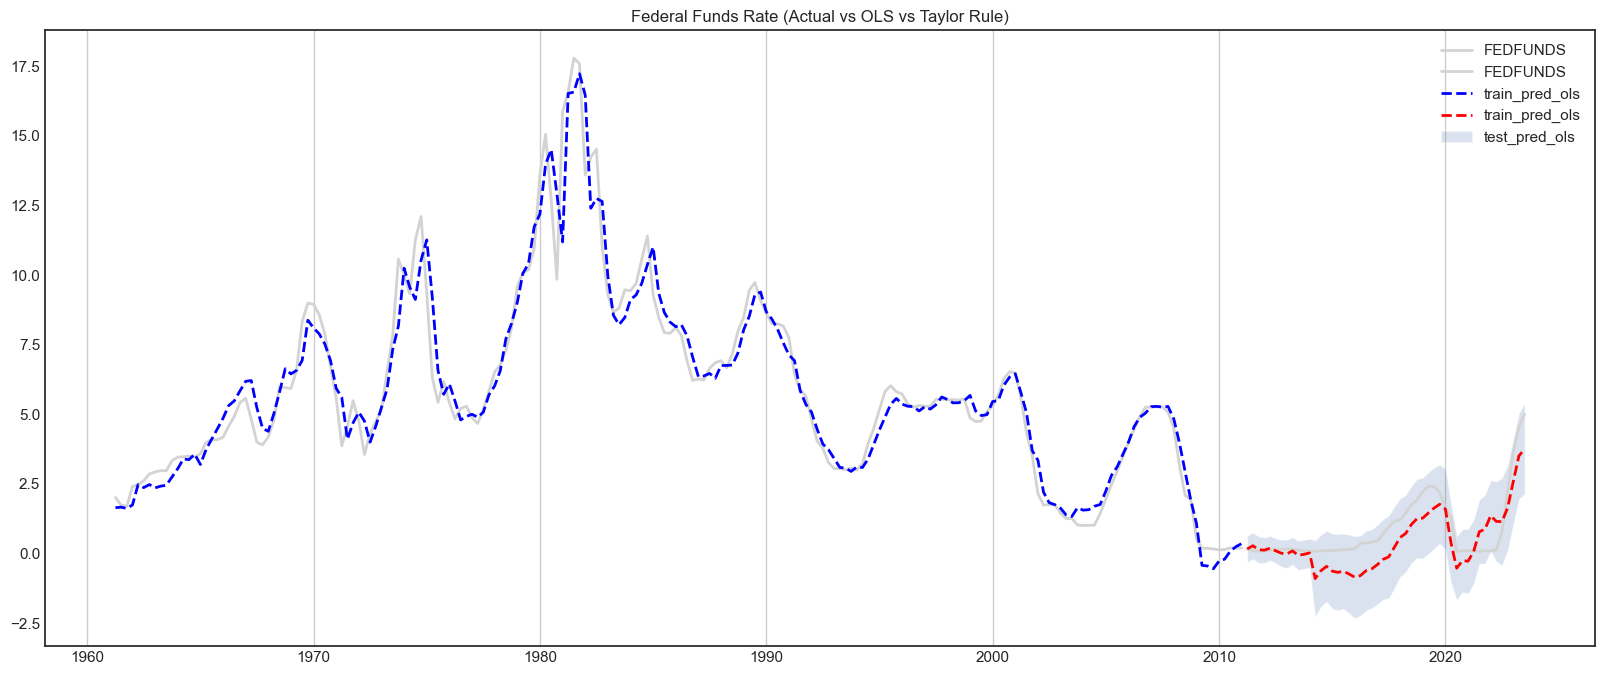

In [20]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_ols['mean'], color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_ols['mean'], color='red', linestyle='--', linewidth=2)
ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# Lasso

In [21]:
# Lasso with 5 fold cross-validation
model = linear_model.LassoCV(cv=5, random_state=rand_int, max_iter=10000)

# Fit model
model.fit(X_train_trf, y_train)

print('model.alpha_: ', model.alpha_)

model.alpha_:  0.03178225849813304


In [22]:
lasso_best = linear_model.Lasso(alpha=model.alpha_)
lasso_best.fit(X_train_trf, y_train)

train_pred_lasso = lasso_best.predict(X_train_trf)

In [23]:
feature_df = pd.DataFrame(lasso_best.coef_, t_fit.get_feature_names_out())
feature_df.columns = ['coef']
feature_df

,coef
num__FEDFUNDS-1,0.886053
num__gap_inf,0.136377
num__gap_gdp,0.165994
num__Real_Interest_Rate,-0.000000
num__gap_ue,-0.051912
cat__onehotencoder__recession_flag_True,-0.265383
cat__onehotencoder__chair_name_Burns,-0.036913
cat__onehotencoder__chair_name_Miller,0.000000
cat__onehotencoder__chair_name_Volcker,0.392010
cat__onehotencoder__chair_name_Greenspan,0.000000


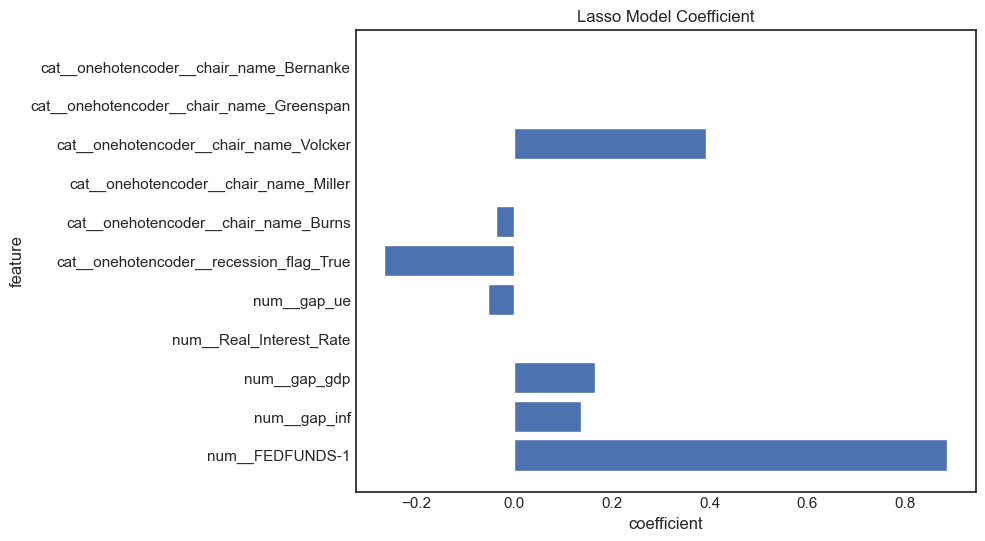

In [24]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(feature_df.index, feature_df['coef'])

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('Lasso Model Coefficient')
plt.grid(False)
plt.show()

In [25]:
model_stats_df = model_results('lasso_train', y_train, train_pred_lasso, X_train.shape[0], 2 , model_stats_df )

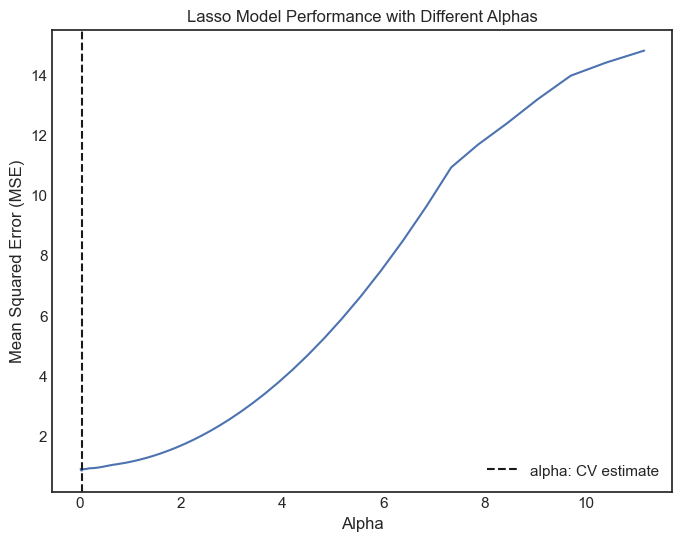

In [26]:
mse_values = np.mean(model.mse_path_, axis=1)

# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.plot(model.alphas_, mse_values)

plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lasso Model Performance with Different Alphas')
plt.grid(False)
plt.show()

(-0.5462506883166667,
 11.716770381983334,
 -1.3522189838772485,
 30.890941211533836)

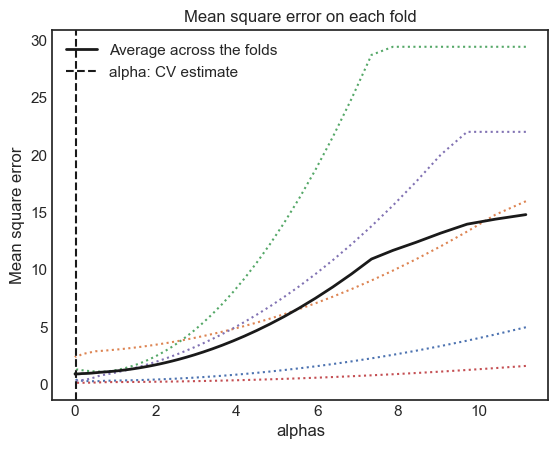

In [27]:
#plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

#ymin, ymax = 50000, 250000
#plt.ylim(ymin, ymax);

In [28]:
test_pred_lasso = lasso_best.predict(X_test_trf)
print('test_pred_lasso: ', test_pred_lasso.shape)

test_pred_lasso:  (50,)


In [29]:
model_stats_df = model_results('lasso_test', y_test, test_pred_lasso, X_test_trf.shape[0], X_test_trf.shape[1] , model_stats_df )

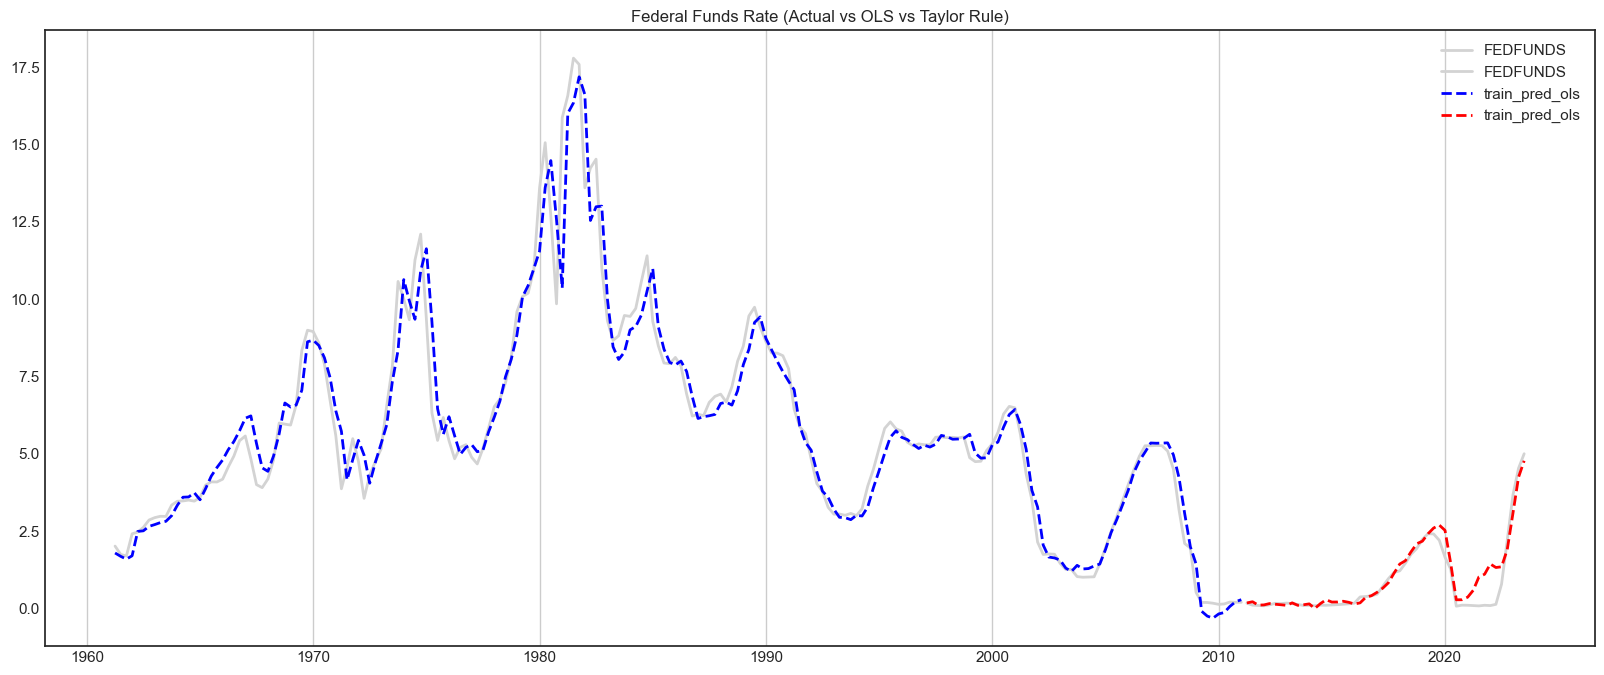

In [30]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_lasso, color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_lasso, color='red', linestyle='--', linewidth=2)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# LGBM

In [31]:
ltb_model = ltb.LGBMRegressor(verbose=-1).fit(X_train_trf, y_train)
train_pred_lgbm = ltb_model.predict(X_train_trf, pred_contrib=False, raw_score=False)

<Axes: >

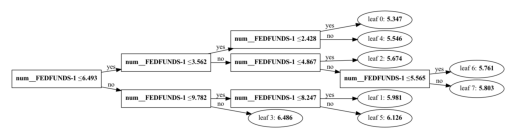

In [32]:
ltb.plot_tree(ltb_model)

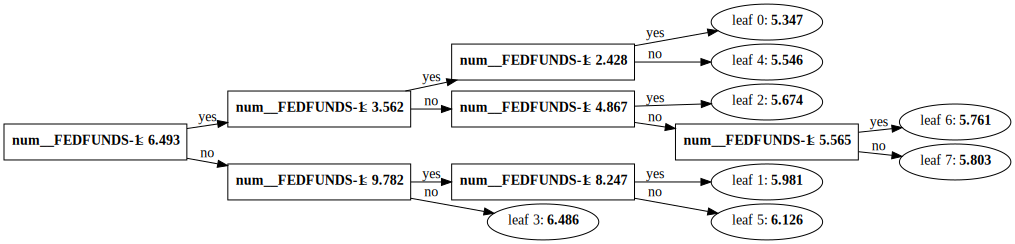

In [33]:
ltb.create_tree_digraph(ltb_model)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

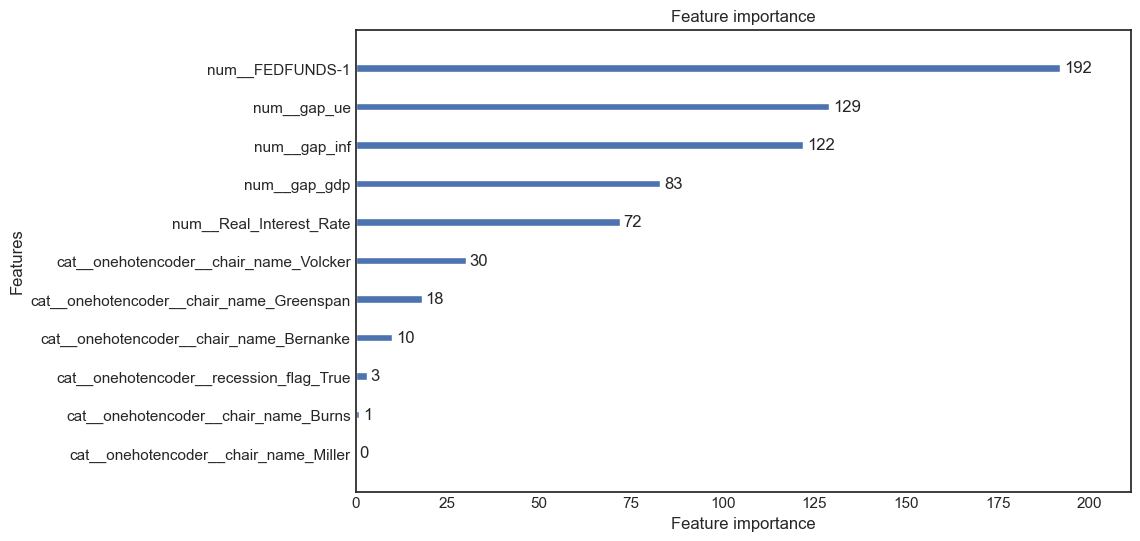

In [34]:
ltb.plot_importance(ltb_model, ignore_zero=False, grid=False, figsize=(10,6))

In [35]:
model_stats_df = model_results('lgbm_train', y_train, train_pred_lgbm, X_train.shape[0], 2  , model_stats_df )

## Test

In [36]:
test_pred_lgbm = ltb_model.predict(X_test_trf, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

(50,)

In [37]:
model_stats_df = model_results('lgbm_test', y_test, test_pred_lgbm, X_train.shape[0], 2 , model_stats_df )

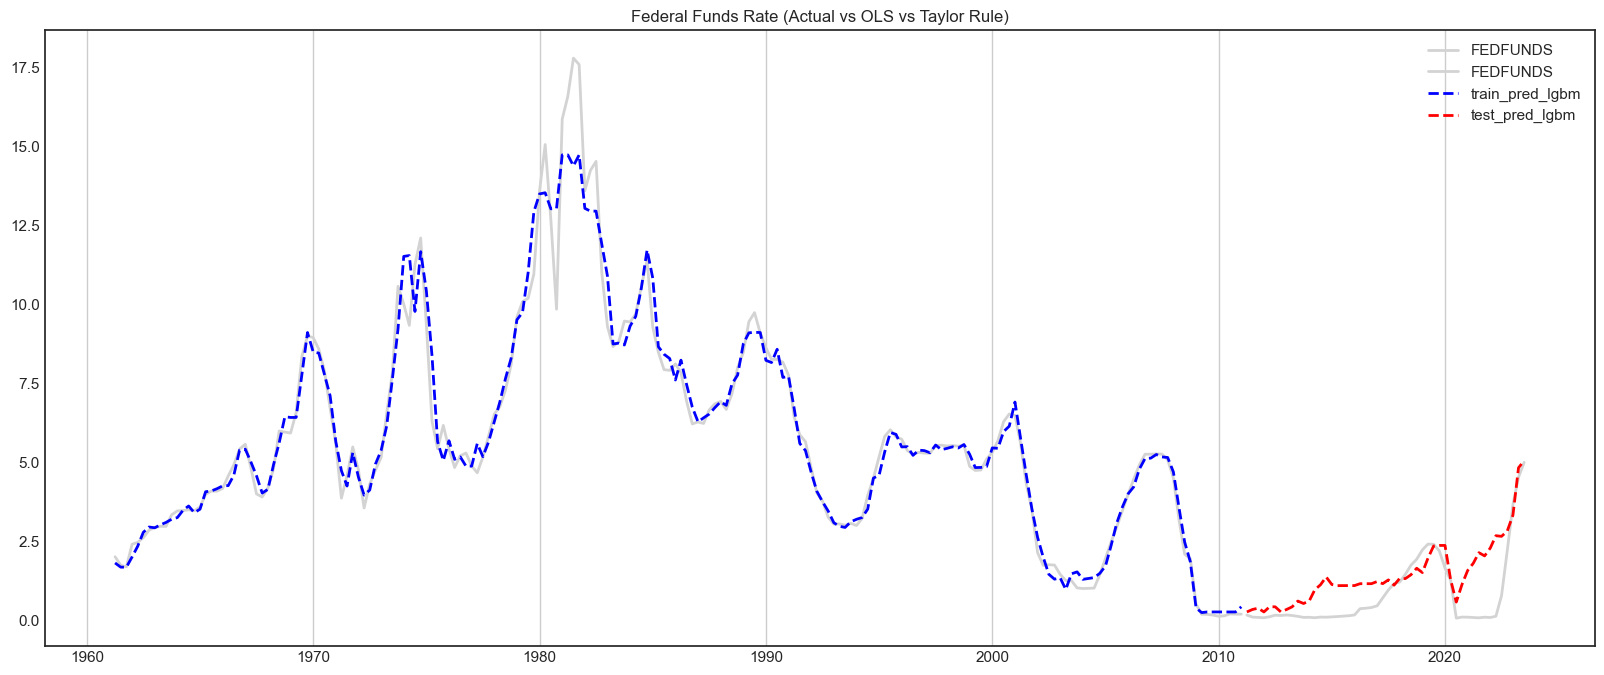

In [38]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# XGB

In [39]:
xgb_model = xgb.XGBRegressor(verbose=-1).fit(X_train_trf, y_train)
train_pred_xgb = xgb_model.predict(X_train_trf)
xgb_model.score(X_train_trf, y_train)

0.9999998593693382

In [40]:
model_stats_df = model_results('xgb_train', y_train, train_pred_xgb, X_train.shape[0], 2 , model_stats_df )

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

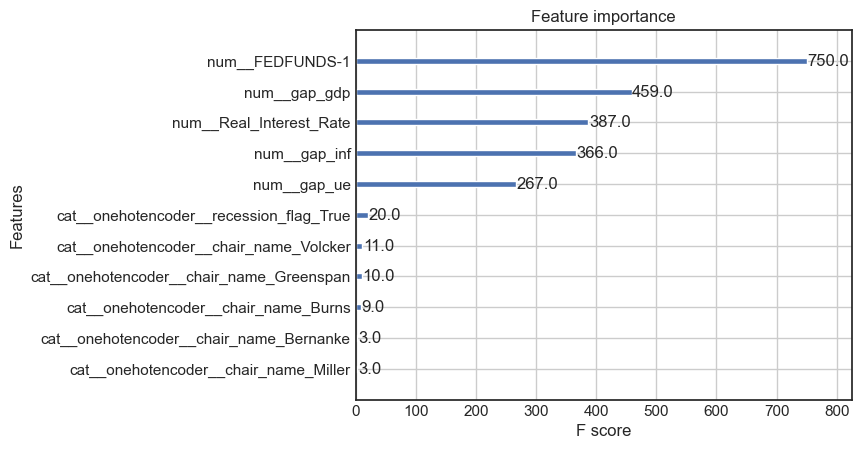

In [41]:
xgb.plot_importance(xgb_model)

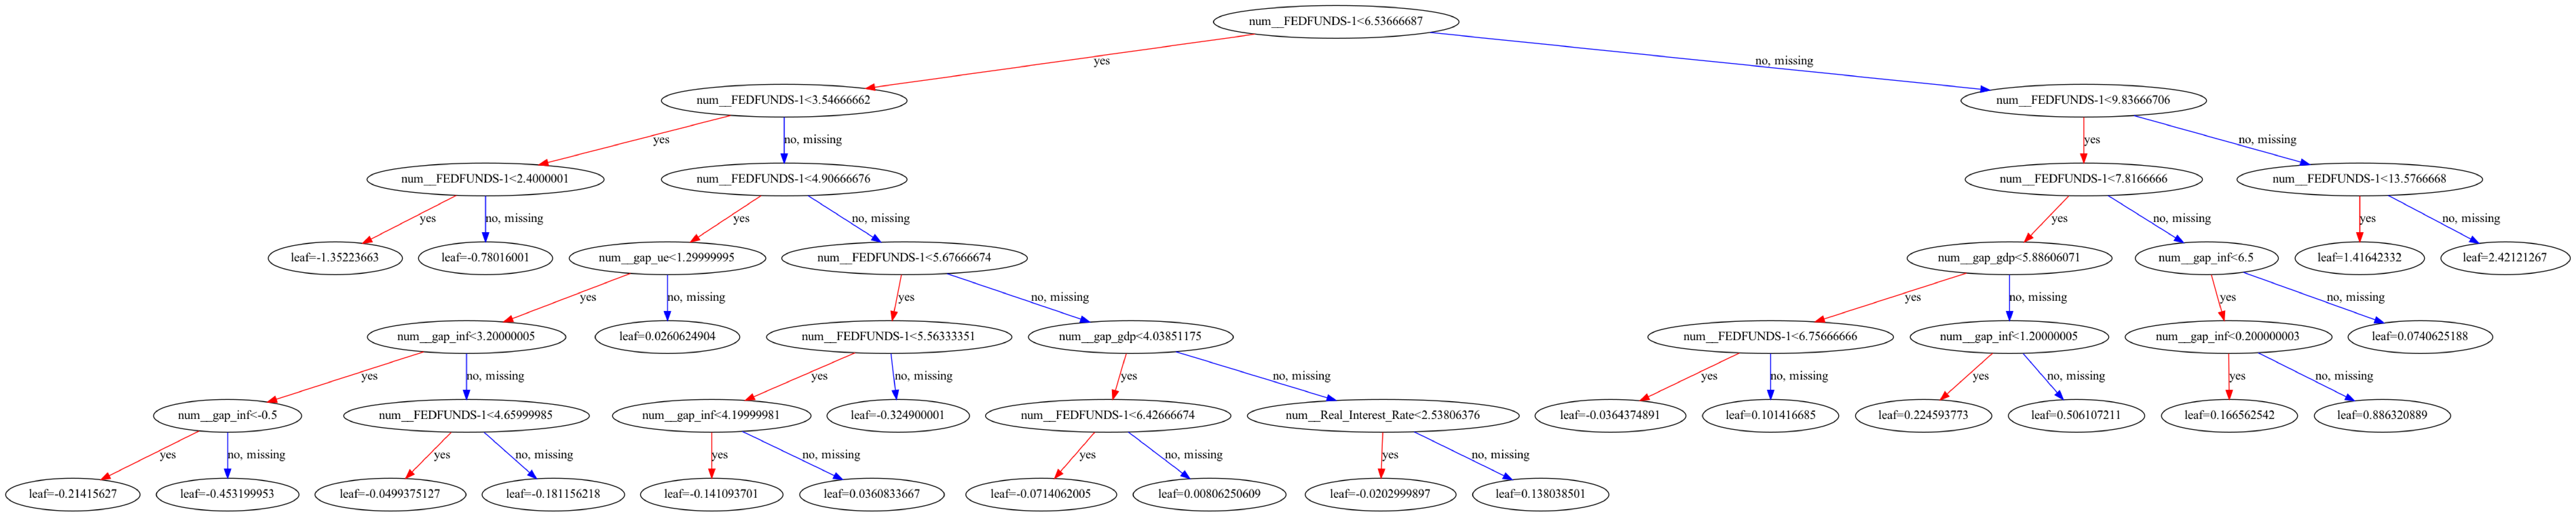

In [42]:
fig, ax = plt.subplots(figsize=(25,10))
#plt.figure(figsize=(12,12))
#xgb.plot_tree(xgb_model, ax=ax)
xgb.plot_tree(xgb_model, ax=ax,fontsize=10)

fig.set_size_inches(150, 100)
fig.savefig('tree.png')

fig.show()

## Test

In [43]:
test_pred_xgb = xgb_model.predict(X_test_trf)
test_pred_xgb.shape

(50,)

In [44]:
model_stats_df = model_results('xgb_test', y_test, test_pred_xgb, X_train.shape[0], 2 , model_stats_df )

# AdaBoostRegressor

In [45]:
ada_model = AdaBoostRegressor().fit(X_train_trf, y_train)
train_pred_ada = ada_model.predict(X_train_trf)

model_stats_df = model_results('ada_test', y_train, train_pred_ada, X_train_trf.shape[0], 2 , model_stats_df )

In [46]:
test_pred_ada = ada_model.predict(X_test_trf)
model_stats_df = model_results('ada_test', y_test, test_pred_ada, X_train_trf.shape[0], 2 , model_stats_df )

# tsa.SARIMAX

taylor2006_df = load_taylor()
#taylor2006_df = taylor2006_df.query('index < "2007-01-01"')
taylor2006_df

train2006_df, test2006_df = time_split(taylor2006_df)

X_train = train2006_df[['FEDFUNDS-1','gap_inf', 'gap_gdp','recession_flag']]
X_train_trf = t_fit.transform(X_train)


y_train = train2006_df['FEDFUNDS']

In [47]:
model = sm.tsa.SARIMAX(y_train, exog=X_train_trf)
result_model = model.fit(disp=False)

result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  200
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -240.674
Date:                Tue, 21 Nov 2023   AIC                            507.347
Time:                        19:51:15   BIC                            550.225
Sample:                    03-31-1961   HQIC                           524.699
                         - 12-31-2010                                         
Covariance Type:                  opg                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
num__FEDFUNDS-1                              0.7319      0.063     11.675      0.000       0.609       0.855
num__gap_inf                                 0.3030      0.059      5.144      0.000       0.188       0.418
num__gap_gdp                                 0.1473      0.103      1.435      0.151      -0.054       0.348
num__Real_Interest_Rate                     -0.0196      0.195     -0.101      0.920      -0.402       0.363
num__gap_ue                                  0.0735      0.163      0.452      0.651      -0.245       0.392
cat__onehotencoder__recession_flag_True     -0.3505      0.244     -1.436      0.151      -0.829       0.128
cat__onehotencoder__chair_name_Burns        -0.2959      0.427     -0.693      0.488      -1.133       0.541
cat__onehotencoder__chair_name_Miller       -0.0011      1.062     -0.001      0.999      -2.082       2.080
cat__onehotencoder__chair_name_Volcker       1.4351      0.579      2.476      0.013       0.299       2.571
cat__onehotencoder__chair_name_Greenspan     0.2483      0.380      0.653      0.514      -0.497       0.994
cat__onehotencoder__chair_name_Bernanke     -0.0101      0.798     -0.013      0.990      -1.575       1.555
ar.L1                                        0.2233      0.073      3.075      0.002       0.081       0.366
sigma2                                       0.6498      0.048     13.679      0.000       0.557       0.743
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               779.72
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
train_result = result_model.get_prediction(start=-len(X_train_trf), dynamic=True)

In [49]:
train_pred_SARIM = train_result.summary_frame()
train_pred_SARIM

FEDFUNDS,mean,mean_se,mean_ci_lower,mean_ci_upper
1961-03-31,1.640465,0.826989,0.019596,3.261335
1961-06-30,1.531802,0.826989,-0.089067,3.152671
1961-09-30,1.478275,0.826989,-0.142595,3.099144
1961-12-31,1.644654,0.826989,0.023784,3.265523
1962-03-31,2.430072,0.826989,0.809203,4.050941
...,...,...,...,...
2009-12-31,-0.452620,0.826989,-2.073489,1.168249
2010-03-31,-0.321552,0.826989,-1.942422,1.299317
2010-06-30,-0.014649,0.826989,-1.635518,1.606220
2010-09-30,0.173414,0.826989,-1.447455,1.794284


In [50]:
model_stats_df = model_results('SARIMAX_train',train_df['FEDFUNDS'], train_pred_SARIM['mean'], X_train.shape[0],X_train.shape[1] , model_stats_df )

## Test

In [51]:
s_idx = len(X_train_trf)
e_idx = s_idx + len(X_test_trf) - 1

test_result = result_model.get_prediction(start=s_idx, end=e_idx, exog=X_test_trf, dynamic=True)

In [52]:
test_pred_SARIM = test_result.summary_frame()
test_pred_SARIM.shape

(50, 4)

In [53]:
predict_ci = test_result.conf_int(alpha=0.5)
predict_ci.head()

,lower FEDFUNDS,upper FEDFUNDS
2011-03-31,-0.279686,0.807736
2011-06-30,-0.210753,0.903451
2011-09-30,-0.235113,0.880410
2011-12-31,-0.277413,0.838176
2012-03-31,-0.179286,0.936305


In [54]:
model_stats_df = model_results('SARIMAX_test', test_df['FEDFUNDS'], test_pred_SARIM['mean'], X_test.shape[0], X_train.shape[1] , model_stats_df )

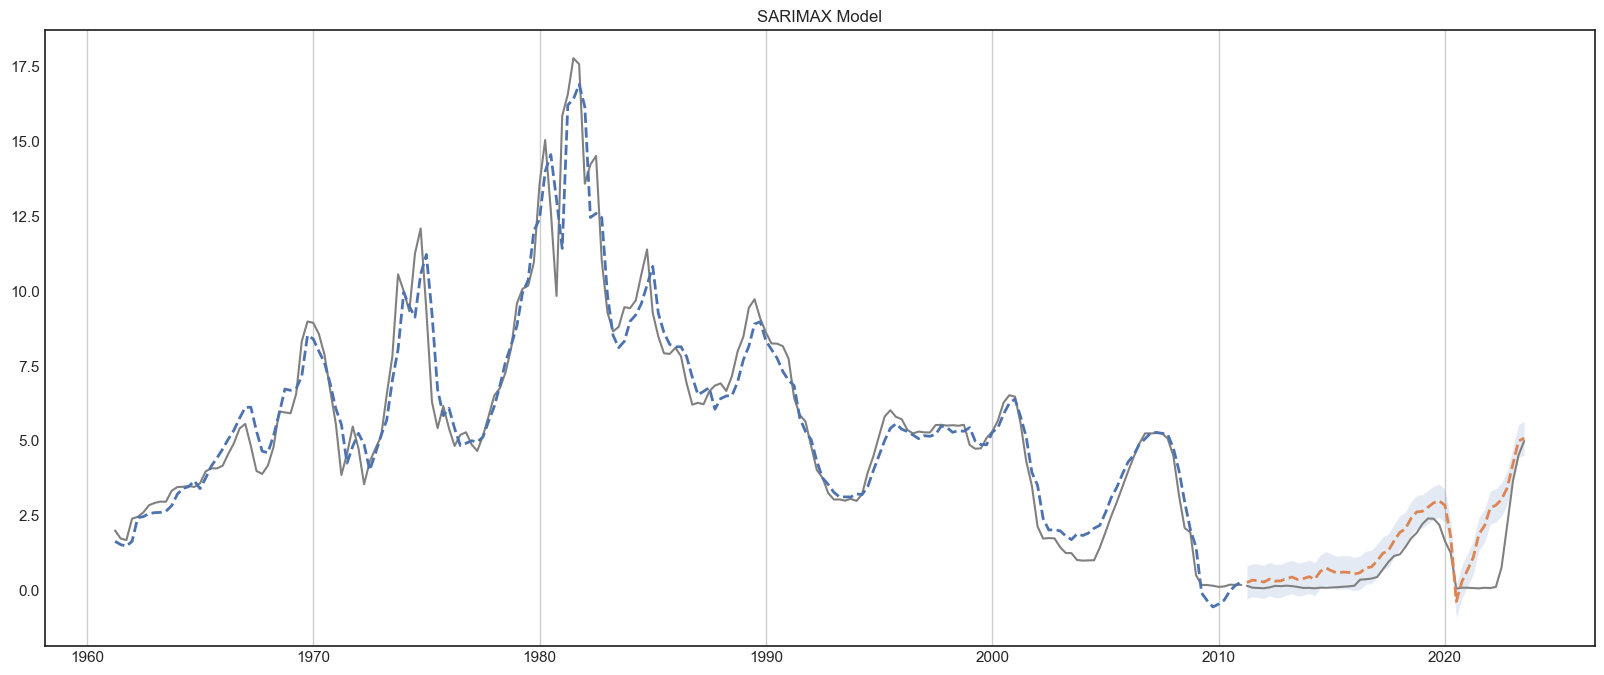

In [55]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'gray')
ax.plot(test_df.index, test_df['FEDFUNDS'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, predict_ci['lower FEDFUNDS'], predict_ci['upper FEDFUNDS'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [56]:
model_stats_df

,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_test,-0.9567,-0.9666,22.8365,4.7788
1,ffef_tr_test,-39.0258,-39.8596,54.7667,7.4005
2,ffef_tr2_test,0.4458,0.4430,6.4680,2.5432
3,ffef_tr2_test,-13.4214,-13.7219,19.7326,4.4421
4,Naive_test,0.9206,0.9206,0.9263,0.9624
5,Naive_test,0.8830,0.8830,0.1601,0.4002
6,ols_train,0.9441,0.9438,0.6525,0.8078
7,ols_test,0.6157,0.6077,0.5258,0.7251
8,lasso_train,0.9401,0.9398,0.6990,0.8360
9,lasso_test,0.8872,0.8582,0.1544,0.3929
